# Homework 1
## Ahmet Buğra Taksuk - 2017402168

- In this homework, we are asked to do some penalized regression approaches for time series representations. In the first part, I solved an optimization problem which tries to minimize the penalty term in the Lasso Regression for each instance so do each class.Also, we applied sub-sampling method to find best parameter for each instance where we leave K = 10 points for test purposes for each iteration.Since there is no readily available library for Lasso Regression for python, I used "cvxpy" library to perform optimization problem. For the second part, I performed similar sub-sampling approach with decision tree classifier to decide on optimum maximum depth and found best depth values. At the third, I compared these two methods' performance with the measure "Mean Squared Value". Finally, for the last part, I defined a 1-NN classifier function to test whether our representations are better when they are get into models and compared their results via "Accuracy" measure. 


#### Reading the data

In [498]:
# Necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [502]:
# Reading Data

df = pd.read_csv("CBF_TRAIN.txt", header = None,delim_whitespace = True)

#### Data Manipulation

In [503]:
# Manipulated the data to set time indices to time and instance information to columns
#Also added class information for each instance

class_ID = df[0]
df.index.name = "Instances"
df.drop(0, axis = 1, inplace = True)
df.insert(0, "Class_ID", class_ID)
df = df.T
df.head(3)

Instances,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Class_ID,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.00000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.000000
1,-0.464276,-0.896972,-0.464696,-0.187190,-1.136017,-0.568709,-0.965839,-0.264302,-0.803716,-1.186422,-0.653308,-0.541876,-1.945327,0.045628,-0.413197,-1.65912,-0.725354,-1.457541,-1.411368,-0.927105,-1.451680,-0.534452,-1.086040,-1.676169,-1.314889,-0.190921,-0.191813,-0.180493,-0.265888,-0.993315
2,-0.555048,-0.685686,-0.567739,-0.620808,-1.319195,-0.888118,-1.644583,-0.290925,-0.048161,-0.893197,-1.295185,-1.016107,-1.449840,-1.129965,-0.400935,-1.00131,-0.837863,-0.668126,-1.208220,-0.648515,-1.445272,-0.954354,-1.199305,-1.839363,-1.350861,-0.616051,-0.046090,-0.988931,0.013128,-0.869419


## Task 1 ) Deciding on Lambda Parameters
- For this part, cvxpy library is used to optimize beta values via measure MSE. To substract Kth point for test purposes at each iteration, I multiplied Beta values with coef matris which sets that indices to zero in order not to include those points in the model. I chose lambda interval as (0,3). The lambda that has the smallest MSE is chosen as the best lambda for that instance. 

In [504]:
best_lambda = []
for i in range(0,30):
    lambdas = []
    scores =  [] # keeps scores for each lambda
    scores = np.array(scores)
    for lmbda in np.arange(0.1, 3, 0.1):
        errors = [] # keeps squared errors for each sub-sample
        for j in range(1,11):
            coef = np.ones((128)) # vector to substract Kth Beta values from the Beta vector
            test = []             # test data for K =10
            test = df[i].values[1+j::10] #Kth values are chosen for testing
            coef[j::10] = 0
            beta = cp.Variable(128) # definition of Beta variables
            y = df[i][1:].values
            objective = cp.Minimize(cp.sum_squares(cp.multiply(y,coef) - cp.multiply(beta,coef)) + lmbda*(cp.tv(beta))) #Objection function
            prob = cp.Problem(objective)
            prob.solve()
            error = np.sum((test - beta.value[j::10])**2) #Squared Errors
            errors.append(error)
        scores = np.append(scores, np.mean(errors)/10) # Mean Squared Errors
        lambdas.append(lmbda) #lambda values
    ind = scores.argmin() #indice which has minimum MSE
    best_lambda.append([i , lambdas[ind]])

In [505]:
lambda_df = pd.DataFrame(best_lambda, columns = ["Instance", "Lambda"])
print("Best Lambda Values for Instances")
lambda_df.T

Best Lambda Values for Instances


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Instance,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
Lambda,1.4,1.3,1.3,2.4,2.0,2.1,2.4,2.1,2.2,0.3,2.0,2.1,1.7,2.5,2.8,2.2,1.1,2.3,2.0,0.7,1.5,1.3,2.3,2.6,2.2,1.5,2.4,2.4,2.5,1.2


### Constructing the model with best lambda values
- The instances has been constructed with the best lambda values and represented with real values again in plots. Blue : Lasso Regression, Red: Real Values. 

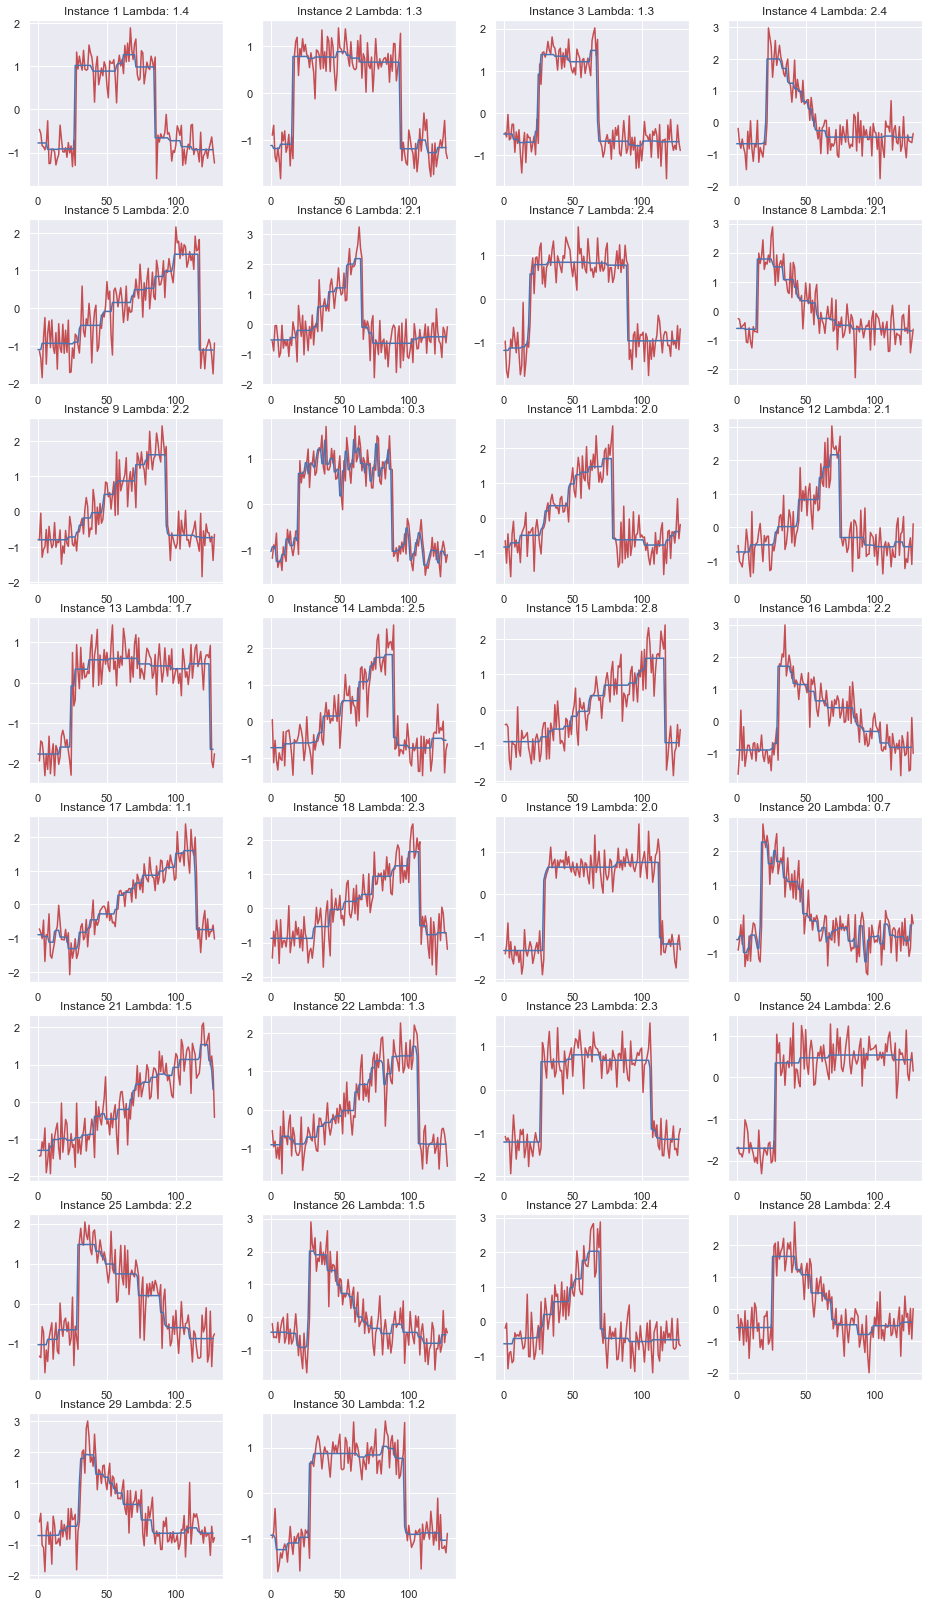

In [511]:
fig = plt.figure(figsize= (16,36))

for i in range(1,31):
    ax = fig.add_subplot(10, 4, i)
    beta = cp.Variable(128)
    y = df[i-1][1:].values
    lmbda = best_lambda[i-1][1]
    objective = cp.Minimize(cp.sum_squares(y - beta) + lmbda*(cp.tv(beta)))
    prob = cp.Problem(objective)
    prob.solve()
    ax.set_title("Instance "+ str(i) + " Lambda: " + str(round(lmbda,3)), size =12)
    ax.plot(df[i-1][1:], c = "r" )
    ax.plot(beta.value, c = "b" )

plt.show();

## Task 2 ) Deciding on the Parameters of Decision Tree
- For this part, similar sub-sampling approach is used but this time using Decision Tree approach. For the depth interval, I set the depth interval to the (1,10). For the optimum maximum depth size determination, I used again MSE, and chose best max depth for the mimimum of MSE for each K sub-sample. 

In [512]:
from sklearn.tree import DecisionTreeRegressor
best_depth = [] 
for i in range(0,30):
    depths = []
    scores =  []
    scores = np.array(scores)
    for depth in np.arange(1,10): # depth interval 
        errors = []
        for j in range(1,11):
            test = []  # test data for K =10
            y = df[i].values[1:]
            index = np.arange(128)
            
            index_test = index[(index + j) % 10 == 0 ] # indices for substracting Kth sub-sample values for test purposes
            index_train = index[(index + j) % 10 != 0 ] # remaining indices
            
            y_train = y[index_train] 
            y_test = y[index_test]
            
            tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
            
            tree_regressor.fit(index_train.reshape(-1,1),y_train)
            error = np.mean((y_test - tree_regressor.predict(index_test.reshape(-1, 1)))**2)
            errors.append(error)
        scores = np.append(scores, np.mean(errors)/10)
        depths.append(depth) #depth values
    ind = scores.argmin() # indice that has minimum SSE
    best_depth.append([i , depths[ind]])

In [517]:
depth_df = pd.DataFrame(best_depth, columns = ["Instance", "Max_Depth"])
depth_df.set_index("Instance", inplace = True)
print("Best Max Depth Values for Instances")
depth_df.T

Best Max Depth Values for Instances


Instance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Max_Depth,5,2,2,3,5,5,2,5,5,2,4,4,4,4,4,4,5,5,2,3,3,5,2,1,4,4,3,4,4,2


### Constructing the model with best lambda values
- The instances has been constructed with the best depth values and represented with real values again in plots. Blue : Decision Tree Regression, Red: Real Values. 

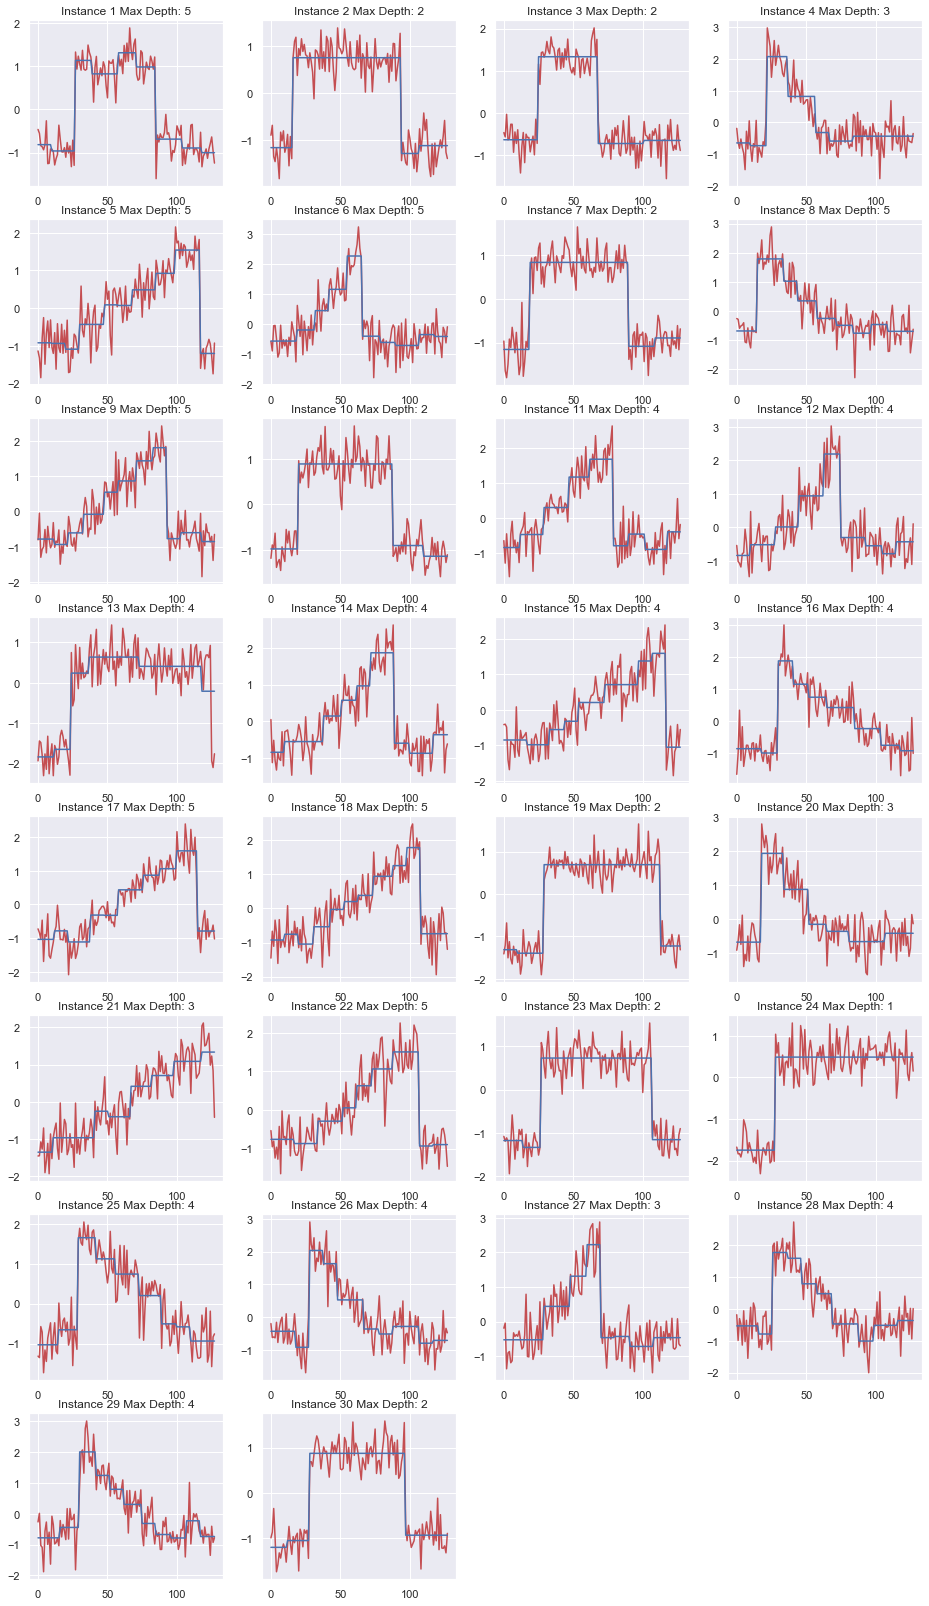

In [518]:
fig = plt.figure(figsize= (16,36))

for i in range(1,31):
    ax = fig.add_subplot(10, 4, i)
    y = df[i-1][1:].values
    depth = best_depth[i-1][1]
    index = np.arange(128)
    tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
    tree_regressor.fit(index.reshape(-1, 1), y)
    ax.set_title("Instance "+ str(i) + " Max Depth: " + str(depth), size =12)
    ax.plot(y, c = "r")
    ax.plot(tree_regressor.predict(index.reshape(-1,1)) , c = "b")



plt.show();

## Task 3 ) Calculating Mean Squared Errors for Each Approach

In [519]:
#Fuunction to calculate MSE for each represenation

def find_mse(array1,array2):    
    difference_array = np.subtract(array1, array2)
    squared_array = np.square(difference_array)
    mse = squared_array.mean()
    return mse

### Fused Lasso Approach 

In [520]:
mse_lasso = []
for i in range(1,31):
    beta = cp.Variable(128)
    y = df[i-1][1:].values
    lmbda = best_lambda[i-1][1]
    objective = cp.Minimize(cp.sum_squares(y - beta) + lmbda*(cp.tv(beta)))
    prob = cp.Problem(objective)
    prob.solve()
    mse_lasso.append(find_mse(y,beta.value))


### Decision Tree Approach 

In [521]:
mse_tree = []
for i in range(1,31):
    y = df[i-1][1:].values
    depth = best_depth[i-1][1]
    index = np.arange(128)
    tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
    tree_regressor.fit(index.reshape(-1, 1), y)
    mse_tree.append(find_mse(y,tree_regressor.predict(index.reshape(-1,1))))

In [524]:
mse_df = pd.DataFrame(mse_lasso, columns = [ "MSE-Lasso"], index = list(range(1,31)))
mse_df["MSE-Tree"] = mse_tree
mse_df.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
MSE-Lasso,0.074966,0.090654,0.073172,0.155288,0.152439,0.191655,0.105229,0.183541,0.141828,0.026689,0.157044,0.201808,0.129328,0.151988,0.187829,0.152840,0.086049,0.182954,0.075015,0.099711,0.146687,0.125816,0.096264,0.128400,0.155842,0.149295,0.202967,0.187854,0.182702,0.078497
MSE-Tree,0.076035,0.104584,0.094068,0.183451,0.156288,0.206896,0.108132,0.185368,0.141705,0.103412,0.162109,0.215506,0.234084,0.158321,0.198816,0.155685,0.112440,0.186760,0.079717,0.207910,0.187439,0.160137,0.101833,0.135358,0.158305,0.196351,0.219982,0.197793,0.187307,0.095031


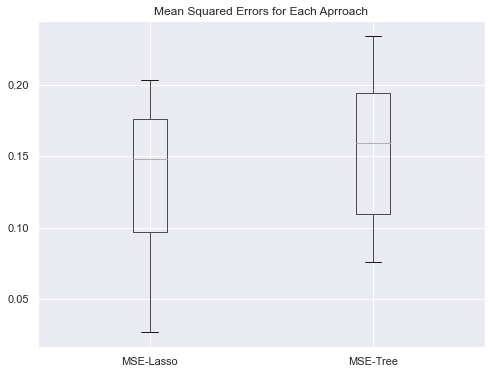

In [525]:
mse_df.boxplot()
plt.title("Mean Squared Errors for Each Aprroach")
plt.show();

- Based on this boxplot, Lasso regression seems to has a lower mean squared error than decision tree regression. Both method's variance seems similar but max and min value for the Lasso regression is also lower than the decision tree approach. Thus, overall performance of Lasso Regression seems like a better option.

## Task ) 4 Comparison of two approaches based on 1-NN Classifier
- For this part, I defined a 1-NN classifier loop to predict the class information of each instance. I performed 1-NN to the original raw series, to Beta values of Lasso Regression and lastly to Decision Tree predictions. Then, each approach's performance on 1-NN classifier based on their "Accuracy" measure. 

### Raw Series 1-NN

In [530]:
predictions_raw = []
acc_vals = []
from scipy.spatial import distance
for i in range(1,31):
    min_dist = 1000000000
    indice = 0
    for j in range(1,31):
        if(i!=j):
            # 1-NN Classifier block to decide on the label of the point
            dist = distance.euclidean(df[i-1][1:], df[j-1][1:])
            if(dist<min_dist):
                min_dist = dist
                indice = j-1
    predictions_raw.append(df[indice].values[0]) #Nearest Neighbor's Label is chosen 


from sklearn.metrics import accuracy_score
acc_vals.append(accuracy_score(labels, predictions_raw))

### Lasso 1-NN 

In [531]:
predictions_lasso = []
for i in range(1,31):
    # Lasso Beta values calculation for first prediction
    beta1 = cp.Variable(128)
    y = df[i-1][1:].values
    lmbda = best_lambda[i-1][1]
    objective = cp.Minimize(cp.sum_squares(y - beta1) + lmbda*(cp.tv(beta1)))
    prob = cp.Problem(objective)
    prob.solve()
    min_dist = 1000000000
    indice = 0
    for j in range(1,31):
        if(i!=j):
            # Lasso Beta values calculation for scond prediction          
            beta2 = cp.Variable(128)
            y = df[j-1][1:].values
            lmbda = best_lambda[j-1][1]
            objective = cp.Minimize(cp.sum_squares(y - beta2) + lmbda*(cp.tv(beta2)))
            prob = cp.Problem(objective)
            prob.solve()
            dist = distance.euclidean(beta1.value,beta2.value) # distance between two regression
            if(dist<min_dist):
                min_dist = dist
                indice = j-1
    predictions_lasso.append(df[indice].values[0])
    
from sklearn.metrics import accuracy_score
acc_vals.append(accuracy_score(labels, predictions_lasso))


### Decision Tree 1-NN

In [532]:
predictions_tree = []
for i in range(1,31):
    # Decision Tree predictions first part
    y = df[i-1][1:].values
    depth = best_depth[i-1][1]
    index = np.arange(128)
    tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
    tree_regressor.fit(index.reshape(-1, 1), y)
    prediction1 = tree_regressor.predict(index.reshape(-1,1))
    min_dist = 1000000000
    indice = 0
    for j in range(1,31):
        if(i!=j):
            # Decision Tree predictions second part
            y = df[j-1][1:].values
            depth = best_depth[j-1][1]
            index = np.arange(128)
            tree_regressor = DecisionTreeRegressor(random_state = 0, max_depth = depth,
                                              min_samples_split = 20, min_samples_leaf = 10)
            tree_regressor.fit(index.reshape(-1, 1), y)
            prediction2 = tree_regressor.predict(index.reshape(-1,1))
            dist = distance.euclidean(prediction1,prediction2)
            if(dist<min_dist):
                min_dist = dist
                indice = j-1
    predictions_tree.append(df[indice].values[0])
    
from sklearn.metrics import accuracy_score
acc_vals.append(accuracy_score(labels, predictions_tree))

In [533]:
acc_df = pd.DataFrame(acc_vals, index = ["Raw Series", "Lasso Regression", "Decision Tree"], columns = ["Accuracy"])
acc_df

,Accuracy
Raw Series,0.833333
Lasso Regression,0.933333
Decision Tree,0.900000


### Conclusion
- Based on the accuracy measures, we are better off to classify the instances when we are to represent the CBF data with Lasso regression and Decision Tree also better than straightforward 1-NN classification.